In [3]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, img_as_float
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed")

print("Path to dataset files:", path)

100%|██████████| 6.40G/6.40G [01:15<00:00, 91.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1


In [5]:
import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1/im_Koilocytotic/im_Koilocytotic/CROPPED/084_02_cyt.dat
/root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1/im_Koilocytotic/im_Koilocytotic/CROPPED/107_03.bmp
/root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1/im_Koilocytotic/im_Koilocytotic/CROPPED/086_01_nuc.dat
/root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1/im_Koilocytotic/im_Koilocytotic/CROPPED/101_02_cyt.dat
/root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1/im_Koilocytotic/im_Koilocytotic/CROPPED/114_07_nuc.dat
/root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1/im_Koilocytotic/im_Koilocytotic/CROPPED/121_08_cyt.dat

In [6]:
# 1. Load and Preprocess the Data
# -----------------------------
# Define data directory
base_dir = path
categories = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic",
              "im_Parabasal", "im_Superficial-Intermediate"]

# Load Images and Labels
image_paths = []
labels = []

for idx, category in enumerate(categories):
    category_path = os.path.join(base_dir, category, category, "CROPPED")
    for file in os.listdir(category_path):
        if file.endswith(('.bmp', '.jpg', '.png')):
            image_paths.append(os.path.join(category_path, file))
            labels.append(idx)

# Convert to DataFrame
df = pd.DataFrame({"image_path": image_paths, "label": labels})
print(f"Loaded {len(df)} images.")

Loaded 4049 images.


In [53]:
image_counts = {}

for category in categories:
    category_path = os.path.join(base_dir, category, category, "CROPPED")
    image_counts[category] = len([f for f in os.listdir(category_path) if f.endswith(('.bmp', '.jpg', '.png'))])

print(image_counts)

{'im_Dyskeratotic': 813, 'im_Koilocytotic': 825, 'im_Metaplastic': 793, 'im_Parabasal': 787, 'im_Superficial-Intermediate': 831}


<ipython-input-54-48cc915aeff1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette='viridis')


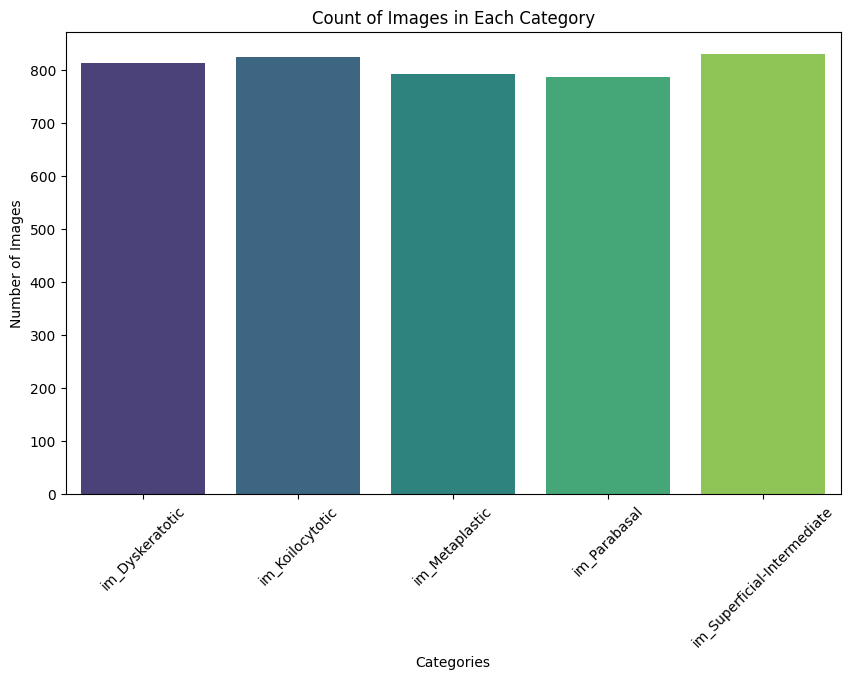

In [54]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette='viridis')
plt.title('Count of Images in Each Category')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

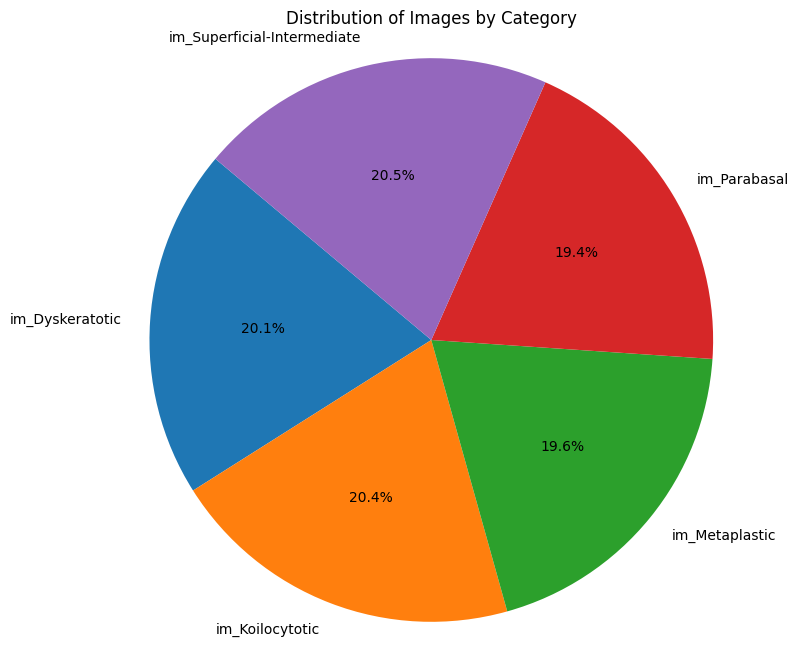

In [55]:
plt.figure(figsize=(8, 8))
plt.pie(image_counts.values(), labels=image_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images by Category')
plt.axis('equal')
plt.show()

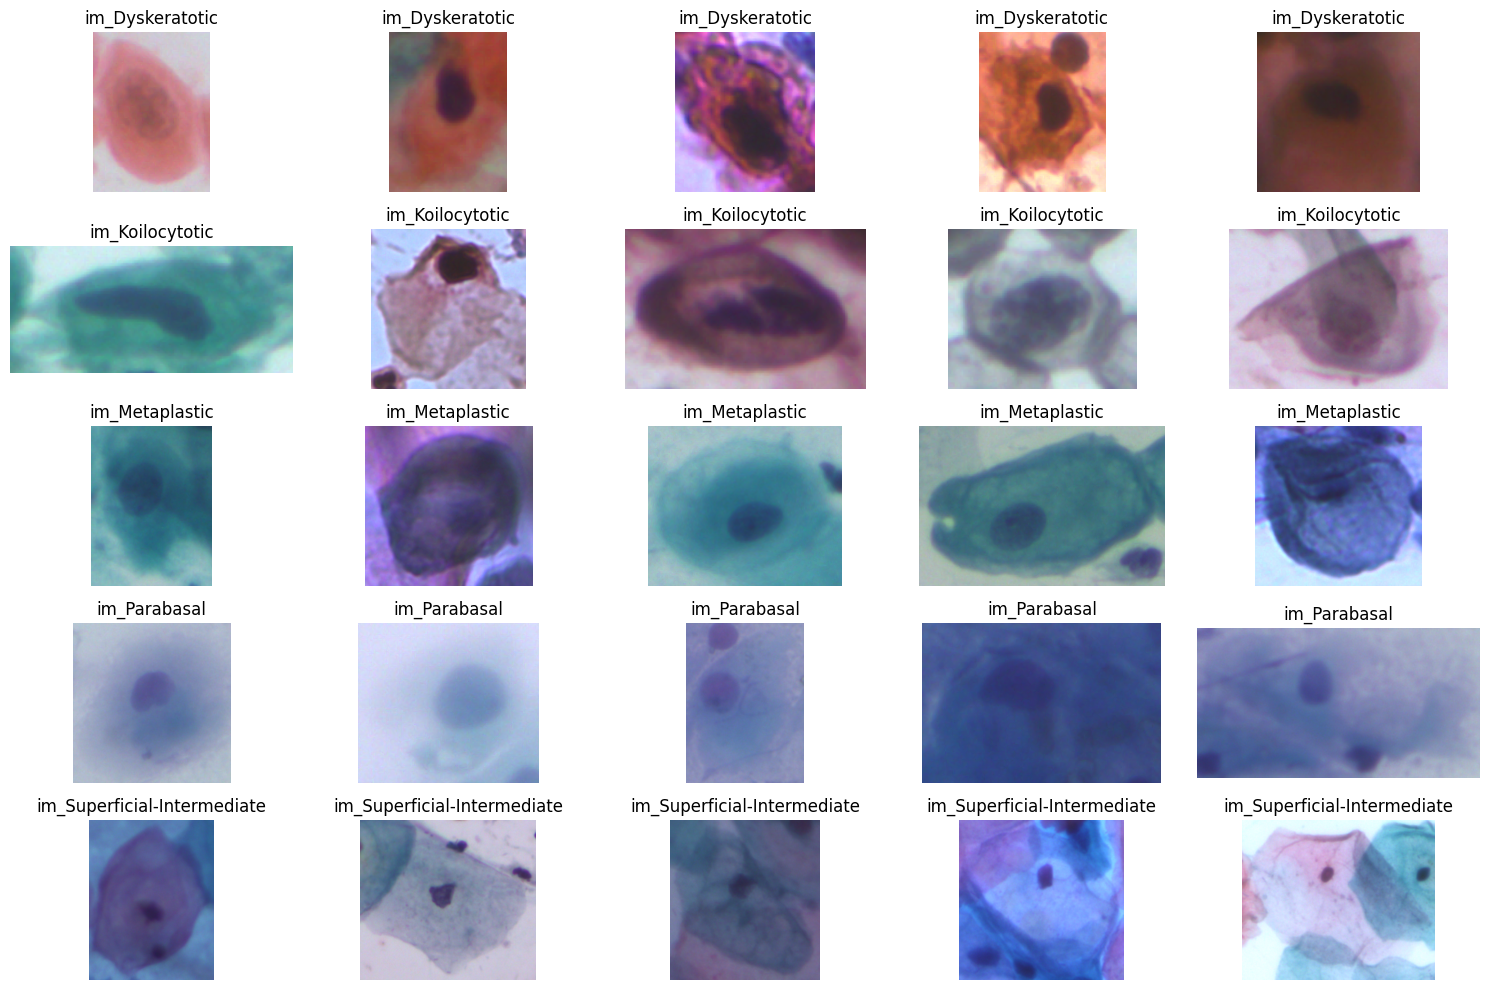

In [9]:
import cv2

def display_sample_images(base_dir, categories, num_images=5):
    plt.figure(figsize=(15, 10))
    for idx, category in enumerate(categories):
        category_path = os.path.join(base_dir, category, category, "CROPPED")
        images = [f for f in os.listdir(category_path) if f.endswith(('.bmp', '.jpg', '.png'))]
        for i in range(num_images):
            img_path = os.path.join(category_path, images[i])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
            plt.subplot(len(categories), num_images, idx * num_images + i + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(base_dir, categories, num_images=5)


Image Path: /root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1/im_Dyskeratotic/im_Dyskeratotic/CROPPED/099_02.bmp
Original Image Shape: (134, 98, 3)
Grayscale Image Shape: (134, 98)


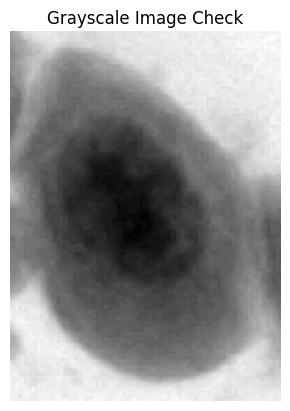

In [10]:
from skimage import io, color

# Load a single image to check
test_image_path = df['image_path'][0]
print("Image Path:", test_image_path)

# Load the image
test_image = io.imread(test_image_path)
print("Original Image Shape:", test_image.shape)

# Convert to grayscale
test_image_gray = color.rgb2gray(test_image)
print("Grayscale Image Shape:", test_image_gray.shape)

# Display the image
plt.imshow(test_image_gray, cmap='gray')
plt.title("Grayscale Image Check")
plt.axis('off')
plt.show()


In [11]:
from skimage import transform

def load_images_from_df(df, image_size=(64, 64)):
    """
    Load and preprocess images from a DataFrame.
    """
    images = []
    for path in df['image_path']:
        img = io.imread(path)
        if len(img.shape) == 3:  # Convert to grayscale only if image has 3 channels
            img = color.rgb2gray(img)
        img_resized = transform.resize(img, image_size, mode='reflect', anti_aliasing=True)
        images.append(img_resized)
    X = np.array(images)
    y = np.array(df['label'])
    return X, y

X, y = load_images_from_df(df, image_size=(64, 64))
print(f"Dataset Shape: {X.shape}")


Dataset Shape: (4049, 64, 64)


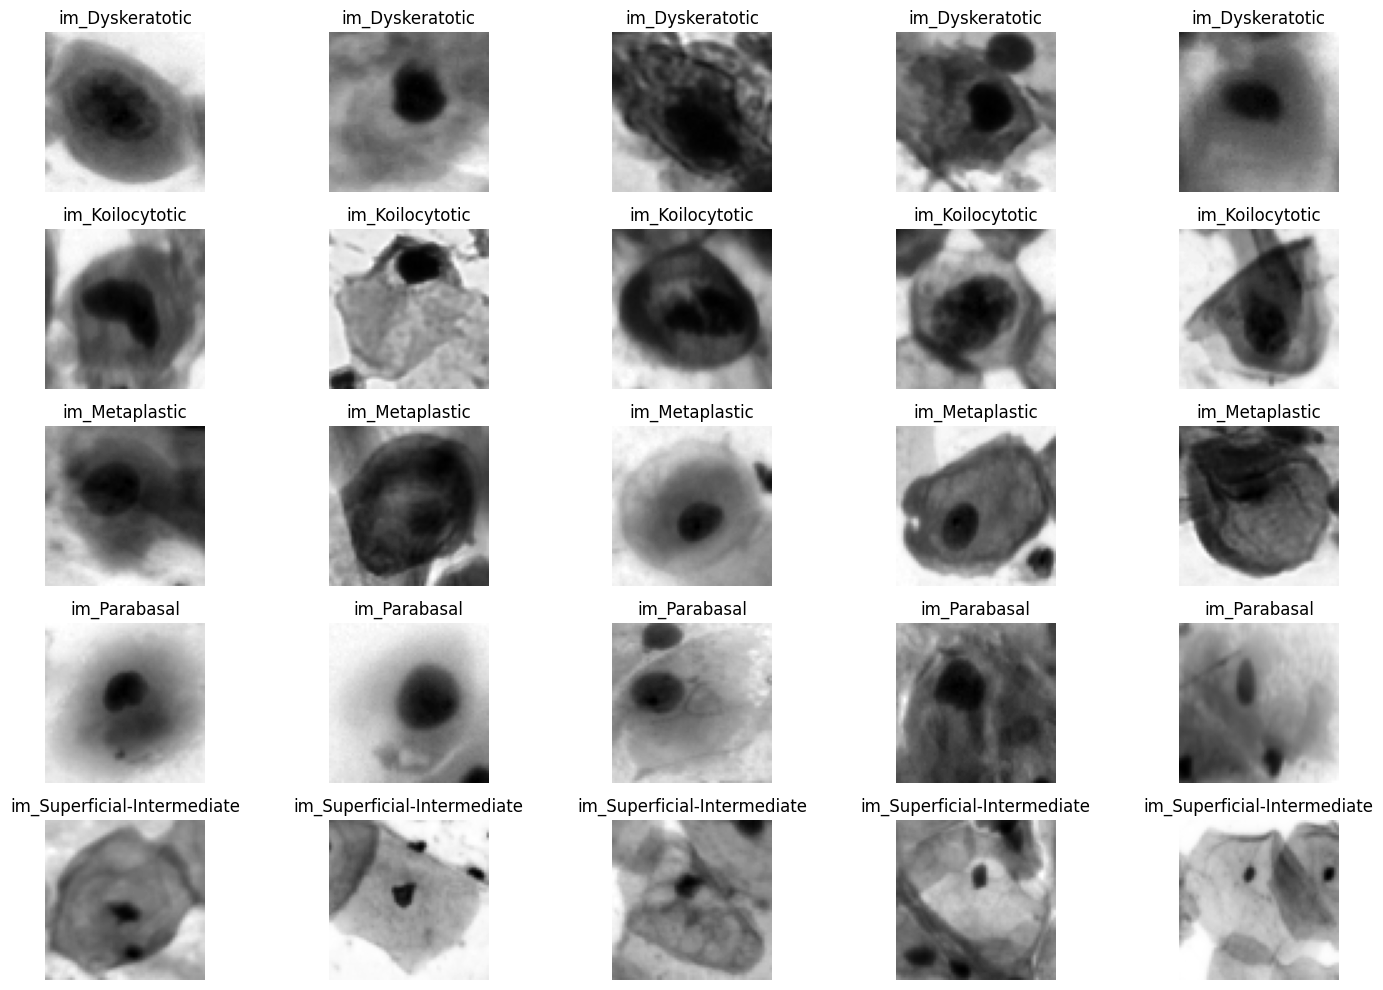

In [12]:
def visualize_images(X, y, categories, num_images=5):
    plt.figure(figsize=(15, 10))
    for idx, category in enumerate(categories):
        category_images = X[y == idx]
        for i in range(min(num_images, len(category_images))):
            plt.subplot(len(categories), num_images, idx * num_images + i + 1)
            plt.imshow(category_images[i], cmap='gray')
            plt.title(category)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

categories = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic",
              "im_Parabasal", "im_Superficial-Intermediate"]

visualize_images(X, y, categories)


In [14]:
 # 2. Feature Extraction
# -----------------------------
# Preprocess Images for LBP and VGG16
from skimage.transform import resize

def preprocess_images(image_paths, size=(64, 64)):
    images = []
    for path in image_paths:
        img = io.imread(path)
        img_gray = color.rgb2gray(img)  # Convert to grayscale
        img_resized = resize(img_gray, size, anti_aliasing=True)  # Resize
        images.append(img_resized)
    return np.array(images)

images = preprocess_images(df['image_path'])
print(f"Preprocessed Images Shape: {images.shape}")

Preprocessed Images Shape: (4049, 64, 64)


In [15]:
from skimage.feature import local_binary_pattern

# Extract LBP Features
def extract_lbp_features(images, radius=1, n_points=8):
    lbp_features = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)  # Convert to uint8
        lbp = local_binary_pattern(img_uint8, n_points, radius, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist / hist.sum()  # Normalize histogram
        lbp_features.append(hist)
    return np.array(lbp_features)

lbp_features = extract_lbp_features(X)
print(f"LBP Features Shape: {lbp_features.shape}")


LBP Features Shape: (4049, 10)


In [16]:
# Load Pretrained VGG16 Model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_vgg16 = Model(inputs=base_model.input, outputs=base_model.output)

# Extract Deep Features
def extract_deep_features(image_paths, model, size=(224, 224)):
    features = []
    for path in image_paths:
        img = load_img(path, target_size=size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        deep_feature = model.predict(img_array, verbose=0)
        features.append(deep_feature.flatten())
    return np.array(features)

deep_features = extract_deep_features(df['image_path'], model_vgg16)
print(f"Deep Features Shape: {deep_features.shape}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Deep Features Shape: (4049, 25088)


In [17]:
# Combine LBP and Deep Features
combined_features = np.hstack((lbp_features, deep_features))
print(f"Combined Features Shape: {combined_features.shape}")

Combined Features Shape: (4049, 25098)


In [18]:
# 3. Dimensionality Reduction
# -----------------------------
pca = PCA(n_components=50)
pca_combined = pca.fit_transform(combined_features)
print(f"PCA Combined Features Shape: {pca_combined.shape}")

PCA Combined Features Shape: (4049, 50)


In [19]:
# 4. Clustering Methods
# -----------------------------
# K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_clusters = kmeans.fit_predict(pca_combined)
kmeans_ari = adjusted_rand_score(df['label'], kmeans_clusters)
print(f"K-Means Adjusted Rand Index (ARI): {kmeans_ari:.4f}")

# GMM
gmm = GaussianMixture(n_components=6,max_iter=500, random_state=42)
gmm_clusters = gmm.fit_predict(pca_combined)
gmm_ari = adjusted_rand_score(df['label'], gmm_clusters)
print(f"GMM Adjusted Rand Index (ARI): {gmm_ari:.4f}")

# DBSCAN
dbscan = DBSCAN(eps=3.0, min_samples=5)
dbscan_clusters = dbscan.fit_predict(pca_combined)
dbscan_ari = adjusted_rand_score(df['label'], dbscan_clusters)
print(f"DBSCAN Adjusted Rand Index (ARI): {dbscan_ari:.4f}")

K-Means Adjusted Rand Index (ARI): 0.3955
GMM Adjusted Rand Index (ARI): 0.3676
DBSCAN Adjusted Rand Index (ARI): 0.0000


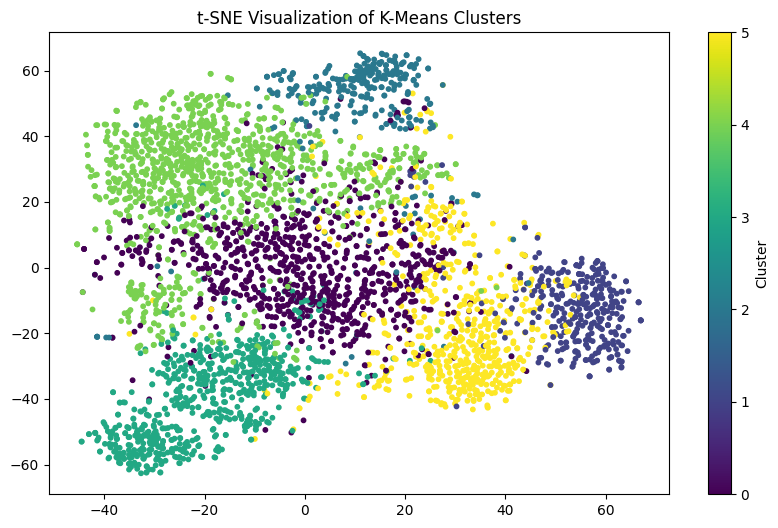

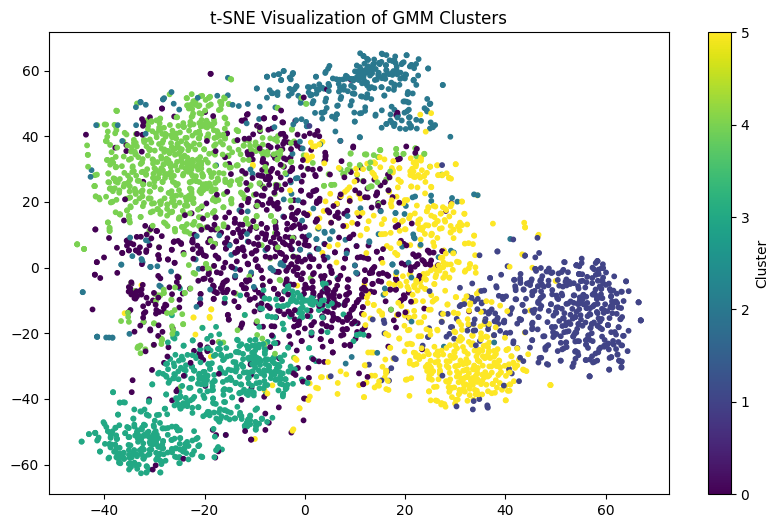

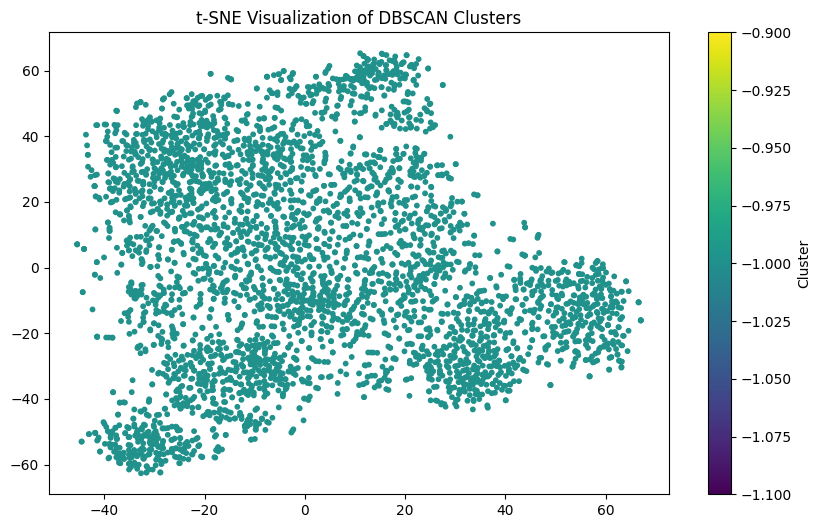

In [20]:
# 5. Visualization
# -----------------------------
from sklearn.manifold import TSNE

# t-SNE Visualization Function
def plot_tsne(features, clusters, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=clusters, cmap='viridis', s=10)
    plt.colorbar(label="Cluster")
    plt.title(title)
    plt.show()

# Visualize Clusters
plot_tsne(pca_combined, kmeans_clusters, "t-SNE Visualization of K-Means Clusters")
plot_tsne(pca_combined, gmm_clusters, "t-SNE Visualization of GMM Clusters")
plot_tsne(pca_combined, dbscan_clusters, "t-SNE Visualization of DBSCAN Clusters")

In [21]:
# 6. Summary of Results
# -----------------------------
print("Summary of Clustering Results:")
print(f"K-Means ARI: {kmeans_ari:.4f}")
print(f"GMM ARI: {gmm_ari:.4f}")
print(f"DBSCAN ARI: {dbscan_ari:.4f}")

Summary of Clustering Results:
K-Means ARI: 0.3955
GMM ARI: 0.3676
DBSCAN ARI: 0.0000


In [50]:

def display_cluster_images(images, clusters, target_cluster, num_images=10):
    """
    Displays sample images from a specific cluster.
    - images: The dataset of images.
    - clusters: The cluster labels for the images.
    - target_cluster: The cluster ID to display.
    - num_images: Number of images to display.
    """
    # Get indices of images in the target cluster
    cluster_indices = np.where(clusters == target_cluster)[0][:num_images]

    # Plot the images
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(cluster_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Sample Images from Cluster {target_cluster}", fontsize=16)
    plt.tight_layout()
    plt.show()


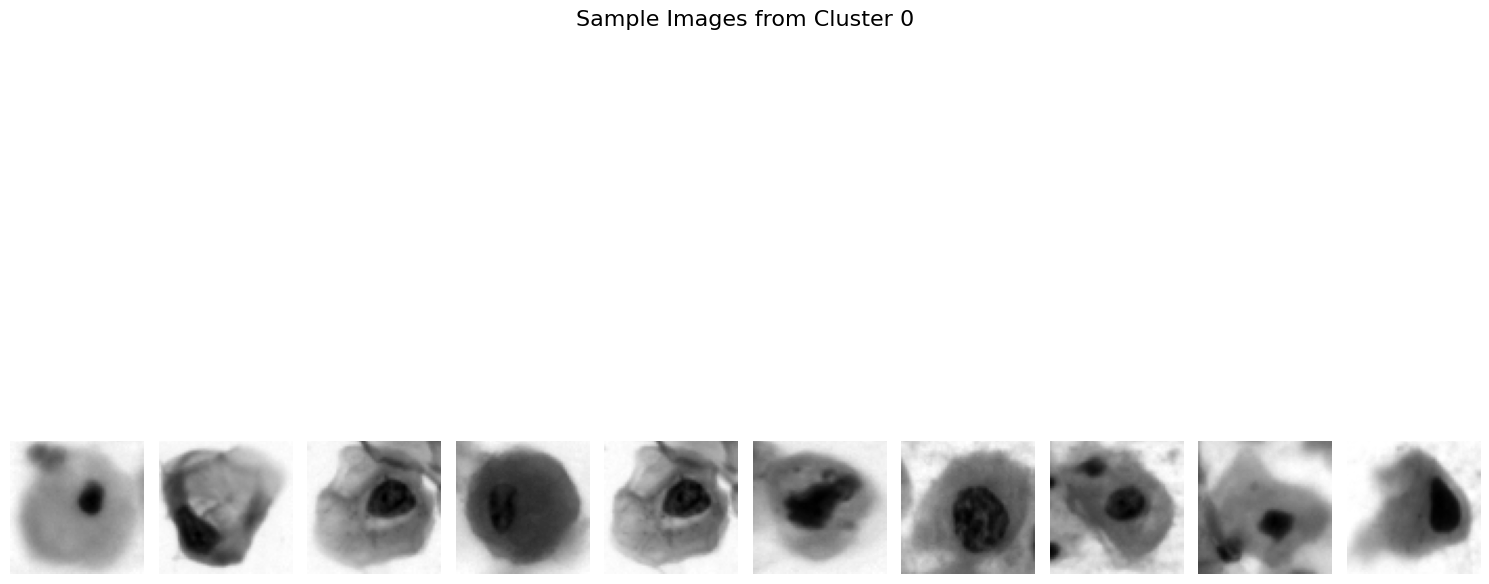

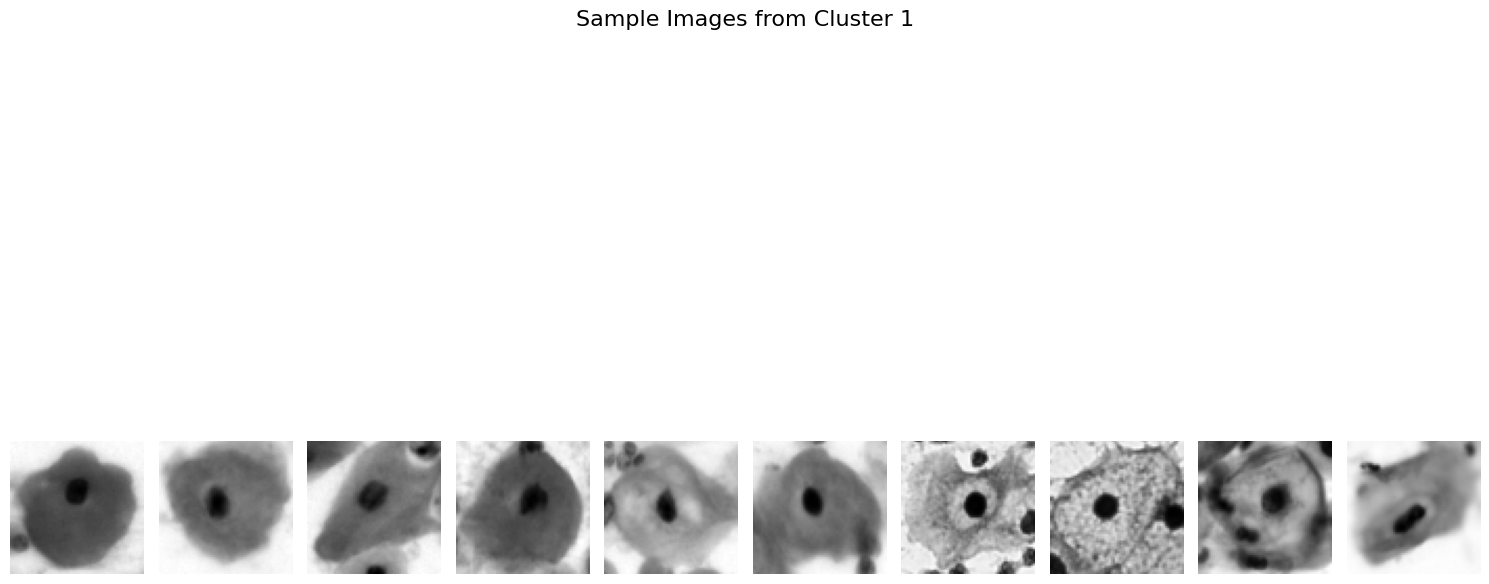

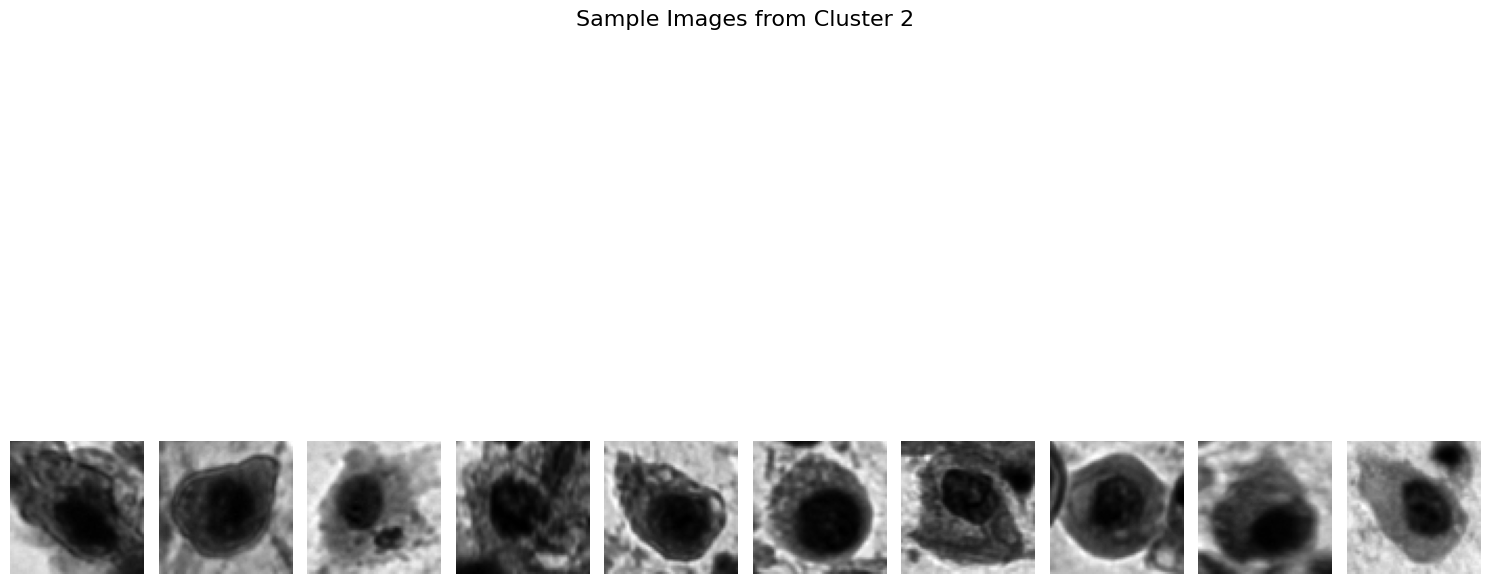

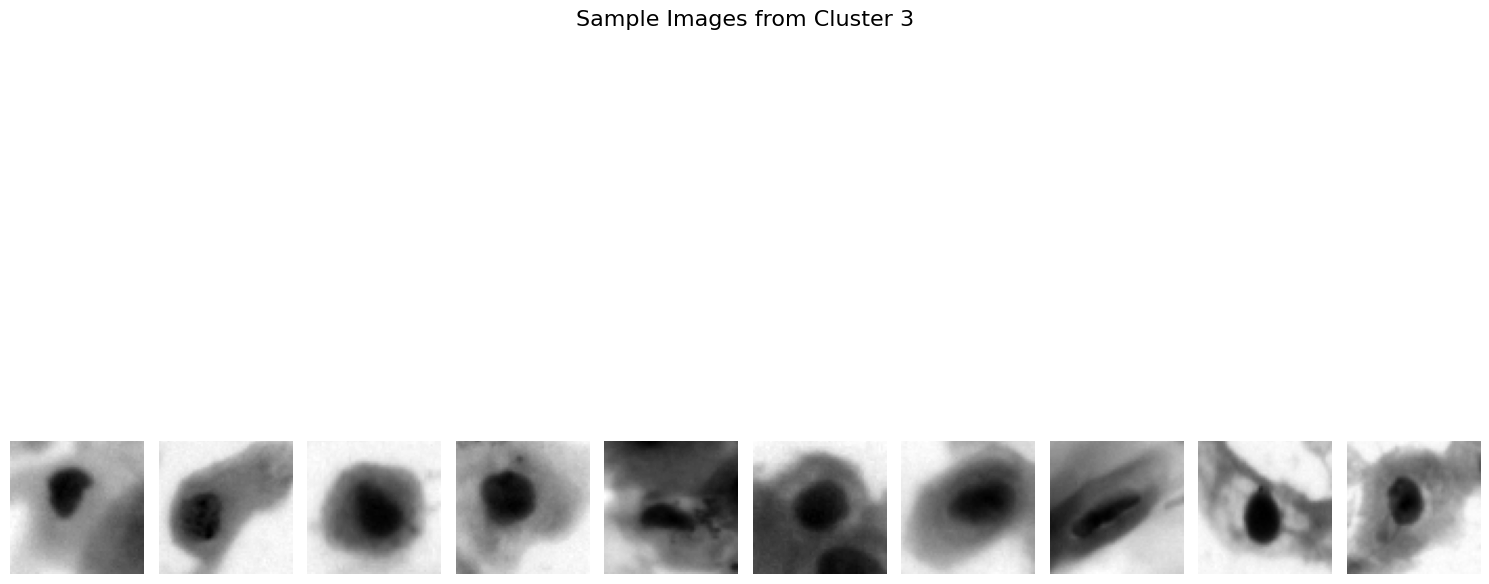

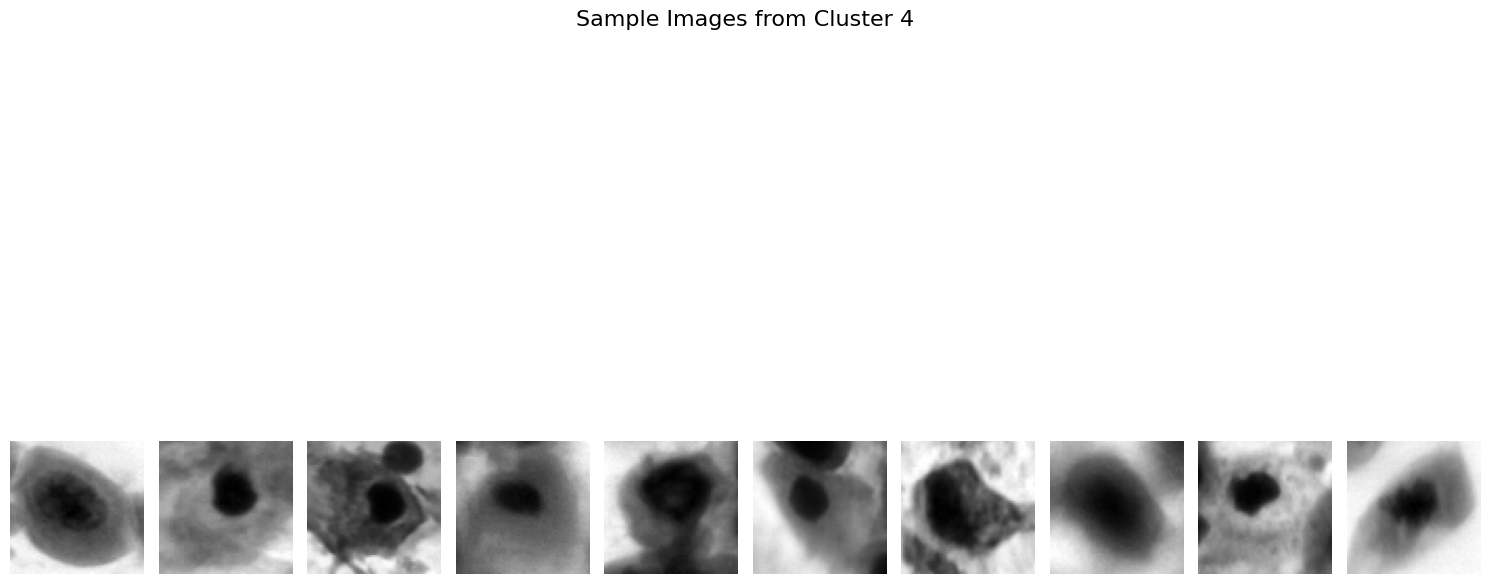

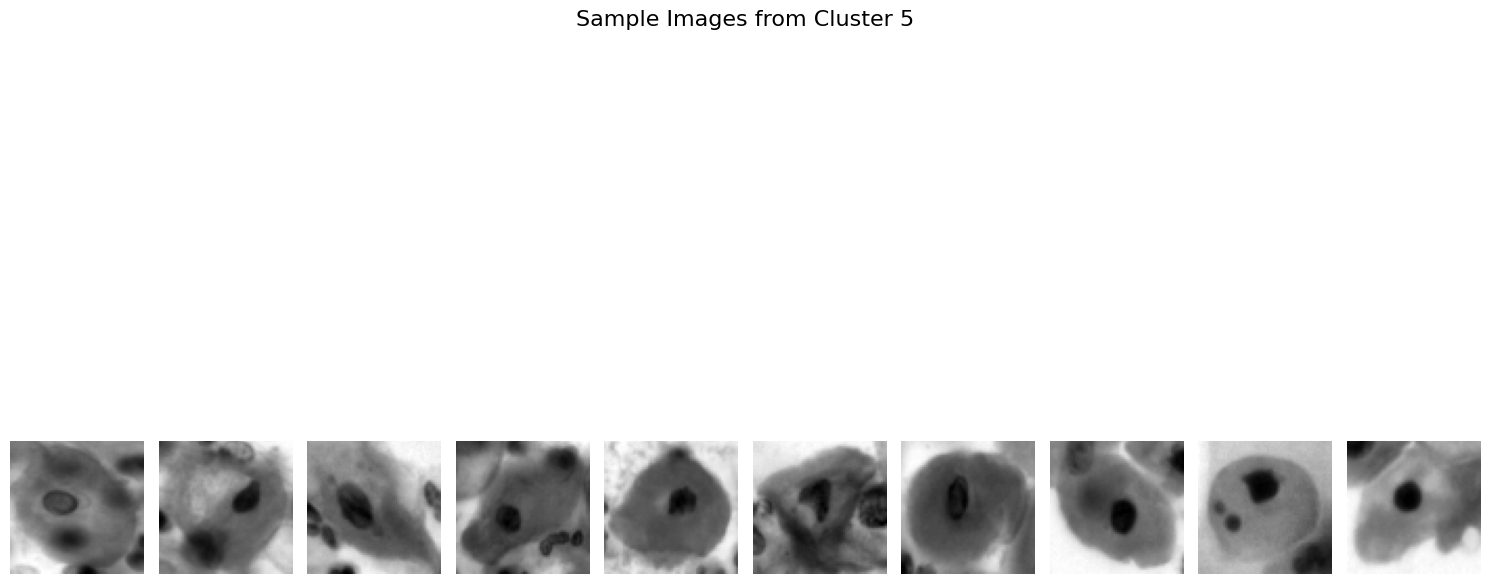

In [51]:
for cluster_id in range(6):  # Adjust for the number of clusters
    display_cluster_images(images, kmeans_clusters, target_cluster=cluster_id, num_images=10)


In [27]:
df['GMM_Tied_Cluster'] = gmm_clusters
cluster_summary = df.groupby(['GMM_Tied_Cluster', 'label']).size().unstack(fill_value=0)
print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
label               0    1    2    3    4
GMM_Tied_Cluster                         
0                  74  465  300   99    8
1                   0    2    1    0  483
2                  92  152  190    0    3
3                   0    5   92  610    0
4                 570  139   27   58    0
5                  77   62  183   20  337


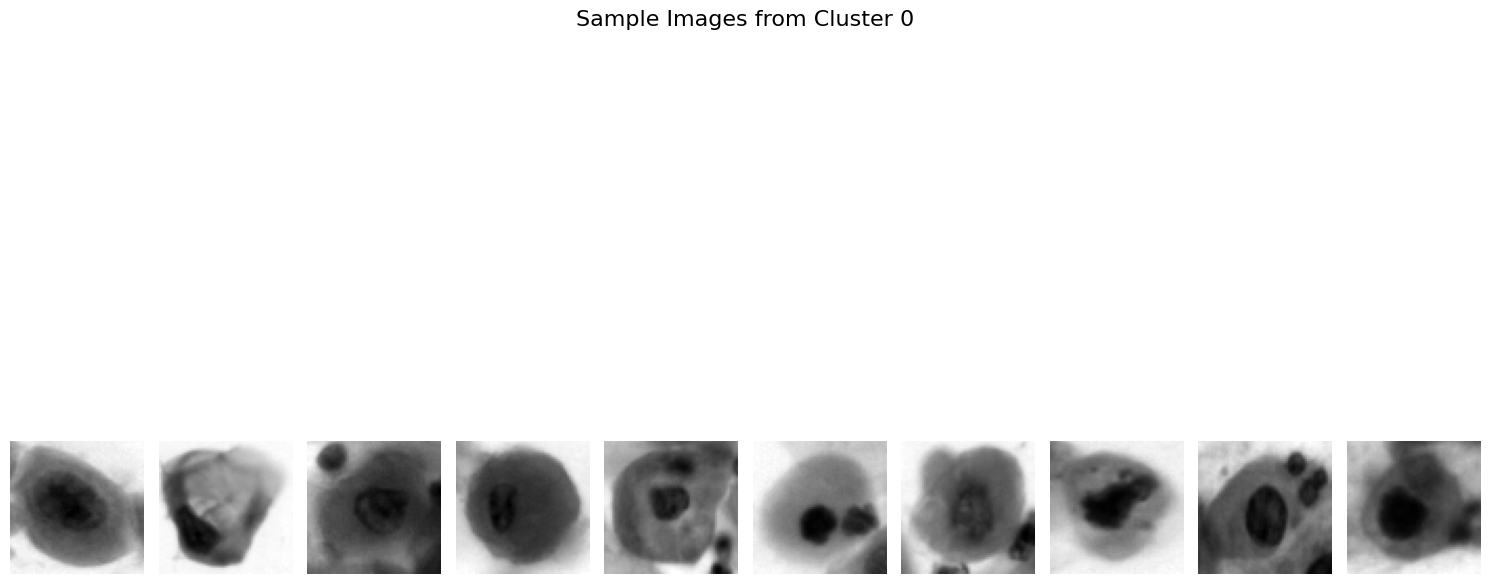

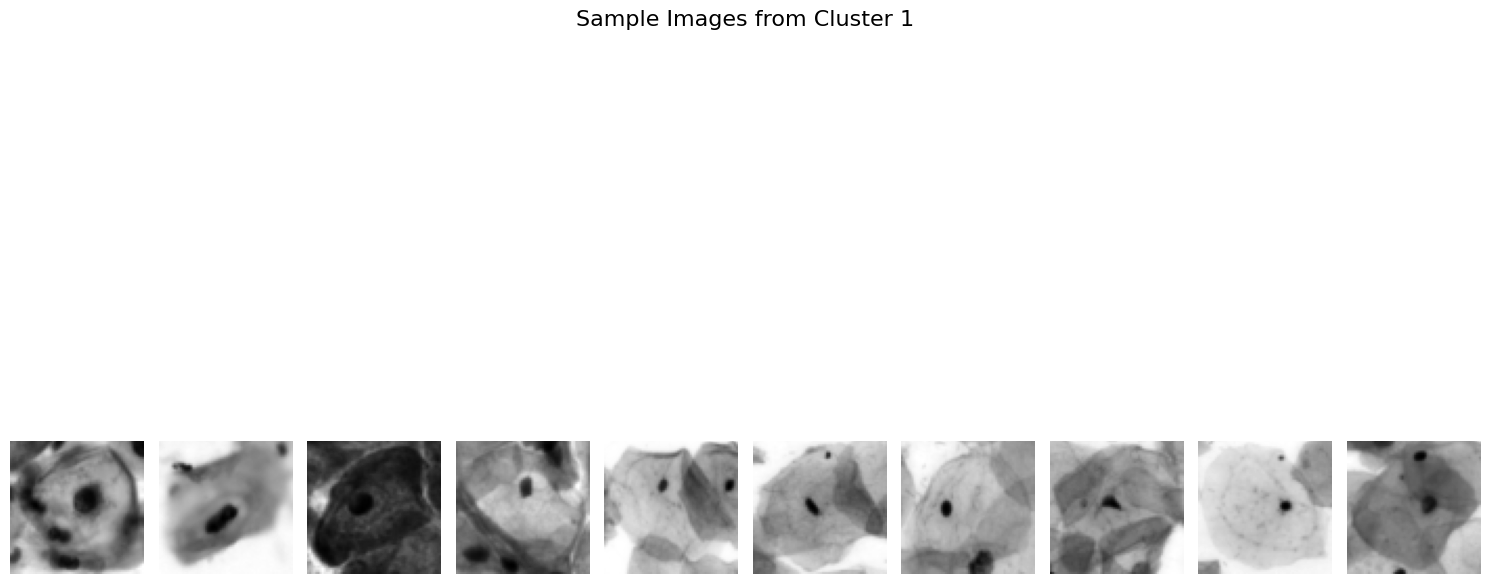

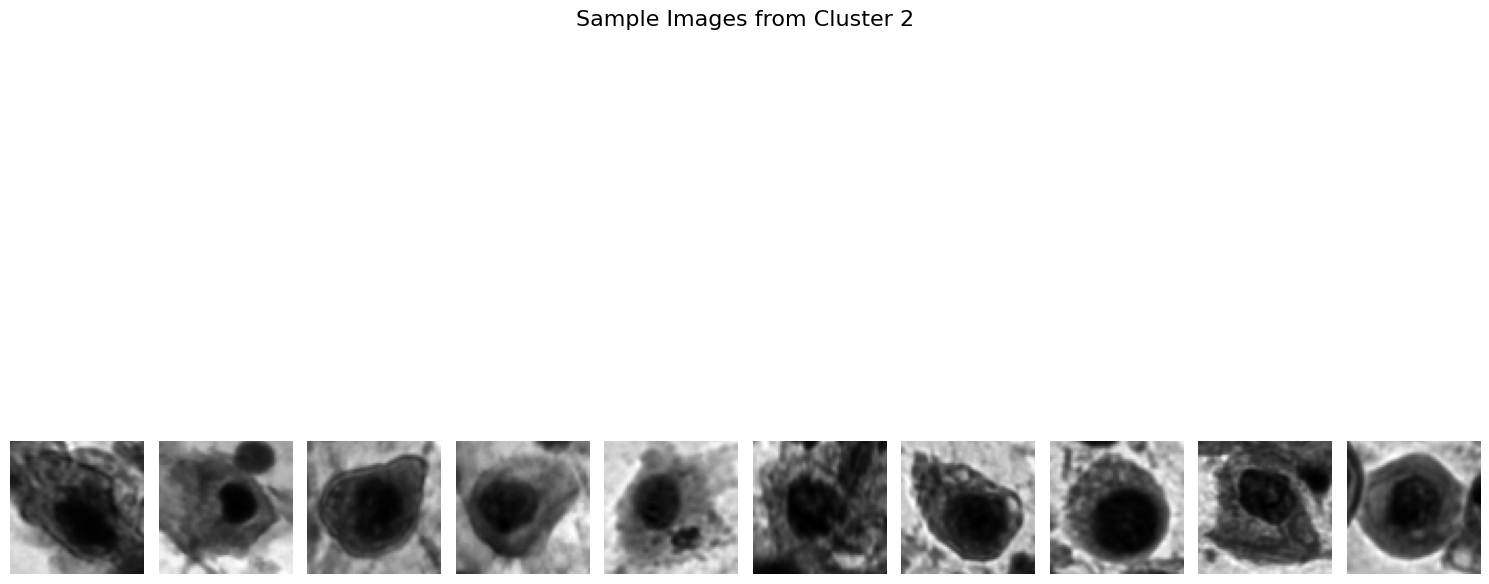

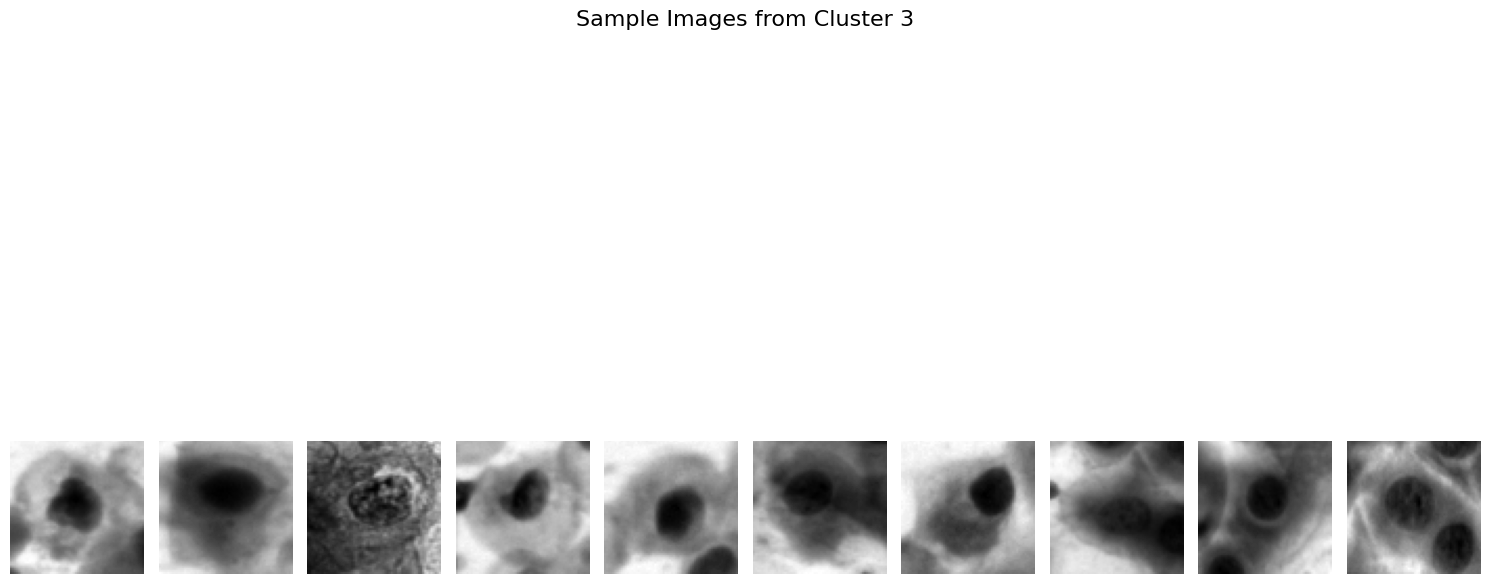

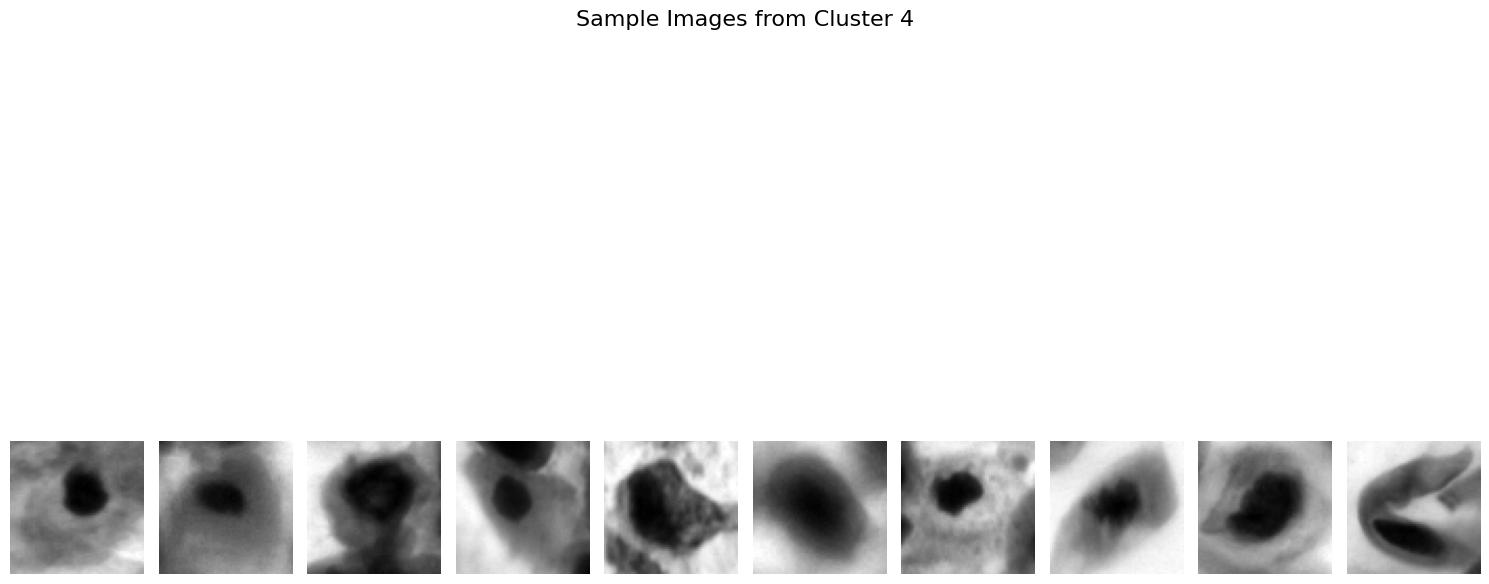

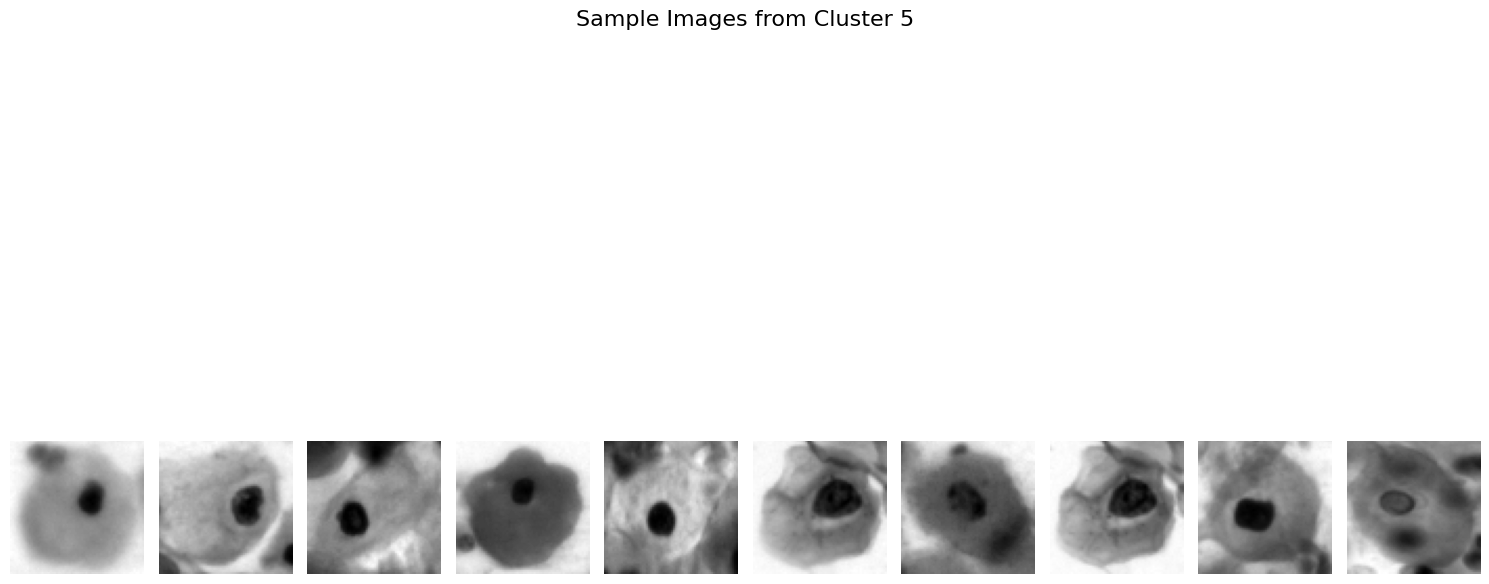

In [52]:
for cluster_id in range(6):  # Adjust for the number of clusters
    display_cluster_images(images, gmm_clusters, target_cluster=cluster_id, num_images=10)


In [28]:
cluster_to_label = {
    0: "im_Dyskeratotic",  # Assuming cluster 0 corresponds to this category
    1: "im_Koilocytotic",
    2: "im_Metaplastic",
    3: "im_Parabasal",
    4: "im_Superficial-Intermediate",
    5: "im_Dyskeratotic"  # Assuming cluster 5 corresponds to this category - Adjust if needed
}

df['Predicted_Label'] = [cluster_to_label.get(cluster, "Unknown") for cluster in kmeans_clusters]
print(df.head())


                                          image_path  label  GMM_Tied_Cluster  \
0  /root/.cache/kagglehub/datasets/prahladmehandi...      0                 0   
1  /root/.cache/kagglehub/datasets/prahladmehandi...      0                 4   
2  /root/.cache/kagglehub/datasets/prahladmehandi...      0                 2   
3  /root/.cache/kagglehub/datasets/prahladmehandi...      0                 2   
4  /root/.cache/kagglehub/datasets/prahladmehandi...      0                 4   

               Predicted_Label  
0  im_Superficial-Intermediate  
1  im_Superficial-Intermediate  
2               im_Metaplastic  
3  im_Superficial-Intermediate  
4  im_Superficial-Intermediate  


K-Means Cluster Summary:
         im_Dyskeratotic  im_Koilocytotic  im_Metaplastic  im_Parabasal  \
Cluster                                                                   
0                     47              387             436             8   
1                      6                4               2             0   
2                     64               80             153             0   
3                      7               14              31           654   
4                    677              297              60           113   
5                     12               43             111            12   

         im_Superficial-Intermediate  
Cluster                               
0                                 36  
1                                339  
2                                  2  
3                                 12  
4                                  3  
5                                439  

GMM Cluster Summary:
         im_Dyskeratotic  im_Koilocytoti

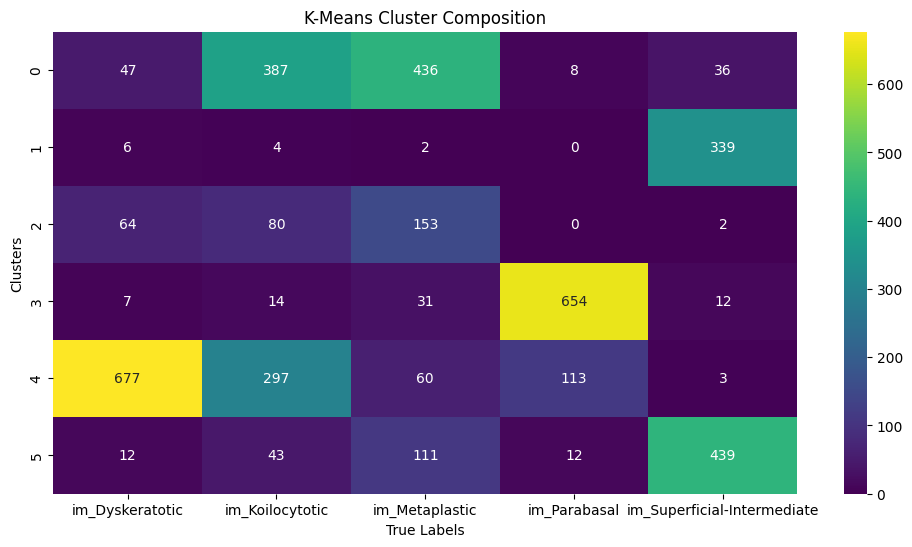

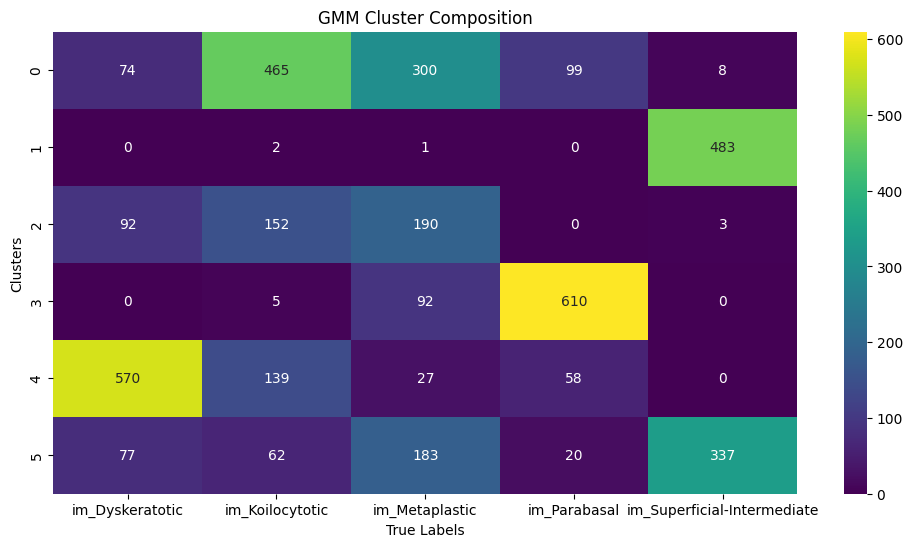

In [29]:
# Analyze Cluster Composition
def analyze_clusters(true_labels, predicted_clusters, categories):
    cluster_summary = pd.DataFrame({
        "True_Label": true_labels,
        "Predicted_Cluster": predicted_clusters
    }).groupby(["Predicted_Cluster", "True_Label"]).size().unstack(fill_value=0)

    cluster_summary.index.name = "Cluster"
    cluster_summary.columns = categories
    return cluster_summary

# K-Means Cluster Analysis
kmeans_summary = analyze_clusters(y, kmeans_clusters, categories)
print("K-Means Cluster Summary:")
print(kmeans_summary)

# GMM Cluster Analysis
gmm_summary = analyze_clusters(y, gmm_clusters, categories)
print("\nGMM Cluster Summary:")
print(gmm_summary)

# Visualize Cluster Composition for K-Means
plt.figure(figsize=(12, 6))
sns.heatmap(kmeans_summary, annot=True, fmt="d", cmap="viridis", cbar=True)
plt.title("K-Means Cluster Composition")
plt.xlabel("True Labels")
plt.ylabel("Clusters")
plt.show()

# Visualize Cluster Composition for GMM
plt.figure(figsize=(12, 6))
sns.heatmap(gmm_summary, annot=True, fmt="d", cmap="viridis", cbar=True)
plt.title("GMM Cluster Composition")
plt.xlabel("True Labels")
plt.ylabel("Clusters")
plt.show()


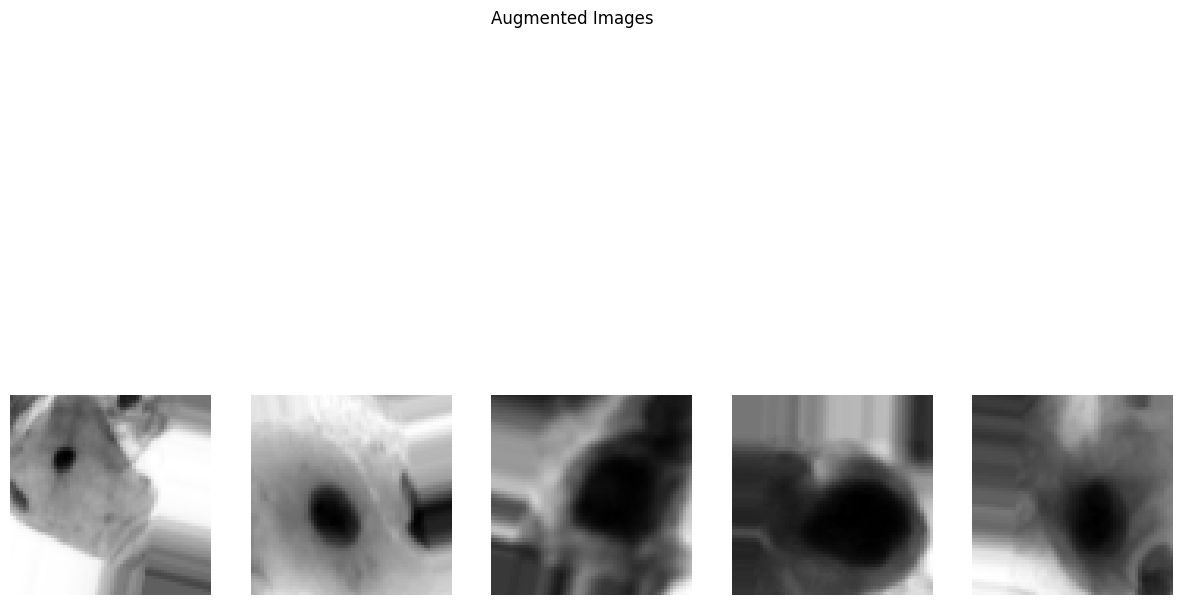

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Augmentation Parameters
datagen = ImageDataGenerator(
    rotation_range=30,       # Rotate images up to 30 degrees
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Zoom in/out
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest',     # Fill pixels for transformations
)

images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
# Fit Augmentation Generator on Images
datagen.fit(images)

# Visualize Augmented Images
def visualize_augmented_images(generator, images, num_images=5):
    augmented_images = next(generator.flow(images, batch_size=num_images))
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(augmented_images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Augmented Images")
    plt.show()

visualize_augmented_images(datagen, images)


In [31]:
augmented_images = datagen.flow(images, labels, batch_size=len(images))
augmented_X, augmented_y = next(augmented_images)
# Combine Original and Augmented Data
X_combined = np.concatenate((images, augmented_X))
y_combined = np.concatenate((labels, augmented_y))

print(f"Combined Dataset Shape: {X_combined.shape}")
print(f"Combined Labels Shape: {y_combined.shape}")


Combined Dataset Shape: (8098, 64, 64, 1)
Combined Labels Shape: (8098,)


In [32]:
from skimage import io, color, transform
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils.validation import check_is_fitted
import numpy as np

def predict_cluster(image_path, deep_model, kmeans_model, pca_model):
    """
    Predicts the cluster for a given test image.
    - image_path: Path to the test image.
    - deep_model: Pretrained deep model (e.g., VGG16).
    - kmeans_model: Trained KMeans model.
    - pca_model: Trained PCA model.
    """
    try:
        # Preprocess Image for LBP
        img = io.imread(image_path)
        img_resized = transform.resize(color.rgb2gray(img), (64, 64), mode='reflect', anti_aliasing=True)
        img_uint8 = (img_resized * 255).astype(np.uint8)
        lbp = local_binary_pattern(img_uint8, P=8, R=1, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 8 + 2))
        hist = hist / hist.sum()

        # Preprocess Image for Deep Features
        img_deep = load_img(image_path, target_size=(224, 224))
        img_deep_array = preprocess_input(np.expand_dims(img_to_array(img_deep), axis=0))
        deep_feature = deep_model.predict(img_deep_array, verbose=0).flatten()

        # Combine Features
        combined_feature = np.hstack((hist, deep_feature))

        # Match Features to PCA Model Input
        if combined_feature.shape[0] != pca_model.n_features_in_:
            if combined_feature.shape[0] > pca_model.n_features_in_:
                combined_feature = combined_feature[:pca_model.n_features_in_]
            else:
                combined_feature = np.pad(combined_feature, (0, pca_model.n_features_in_ - combined_feature.shape[0]), mode='constant')

        combined_feature_pca = pca_model.transform([combined_feature])

        # Predict Cluster
        check_is_fitted(kmeans_model)  # Ensure KMeans is fitted
        predicted_cluster = kmeans_model.predict(combined_feature_pca)[0]
        return predicted_cluster

    except Exception as e:
        print(f"Error processing the image: {e}")
        return None

# Test Prediction
test_image_path = "/content/drive/MyDrive/SIPaKMeD/test _image/149316754-149316779-001.BMP"  # Replace with actual test image path
predicted_cluster = predict_cluster(test_image_path, model_vgg16, kmeans, pca)

if predicted_cluster is not None:
    print(f"Predicted Cluster for Test Image: {predicted_cluster}")
else:
    print("Prediction failed.")


Predicted Cluster for Test Image: 3


In [33]:
# Cluster-to-Label Mapping
cluster_to_label = {
    0: "im_Dyskeratotic",
    1: "im_Koilocytotic",
    2: "im_Metaplastic",
    3: "im_Parabasal",
    4: "im_Superficial-Intermediate",
    5: "im_Dyskeratotic"  # Adjust as necessary based on your analysis
}

# Map Predicted Cluster
predicted_label = cluster_to_label.get(predicted_cluster, "Unknown")
print(f"Predicted Biological Label for Test Image: {predicted_label}")


Predicted Biological Label for Test Image: im_Parabasal


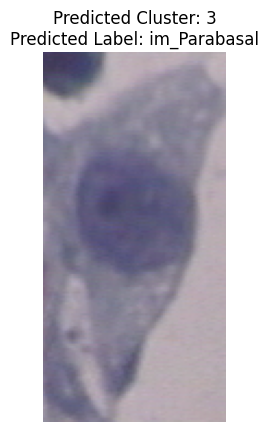

In [34]:
# Visualize Test Image
plt.imshow(io.imread(test_image_path), cmap='gray')
plt.title(f"Predicted Cluster: {predicted_cluster}\nPredicted Label: {predicted_label}")
plt.axis('off')
plt.show()


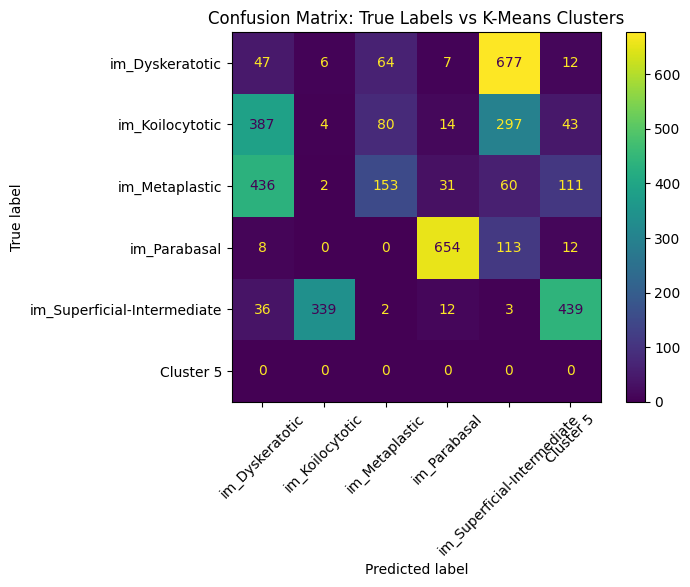

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get unique cluster labels
unique_cluster_labels = np.unique(kmeans_clusters)

# Update categories to match the number of unique cluster labels
display_labels = [categories[i] if i < len(categories) else f'Cluster {i}' for i in unique_cluster_labels]

cm = confusion_matrix(df['label'], kmeans_clusters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Confusion Matrix: True Labels vs K-Means Clusters")
plt.show()


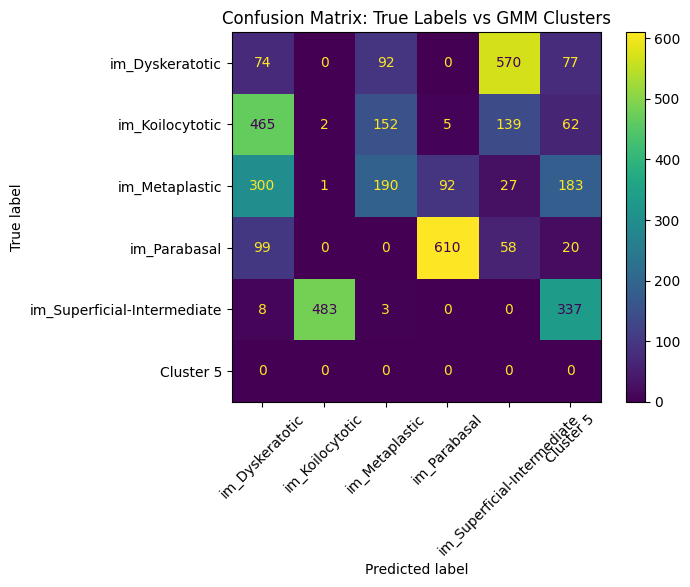

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get unique cluster labels for GMM
unique_gmm_labels = np.unique(gmm_clusters)

# Update display labels to include categories or generic cluster names
display_labels = [categories[i] if i < len(categories) else f'Cluster {i}' for i in unique_gmm_labels]

# Compute the confusion matrix
cm = confusion_matrix(df['label'], gmm_clusters)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Confusion Matrix: True Labels vs GMM Clusters")
plt.show()
